# Digital Processing of Remote Sensing Images
  - Cesar Augusto de Moraes Costa

date: 2023/10/09


# Introduction

  - This notebook has been cloned from [RSGISLib](https://github.com/remotesensinginfo/rsgislib-tutorials) and is being modified to conform to 1-band image segmentation from the CBERS 04A WPM sensor satellite. Segmentation will be an automation process for selecting landslide samples.



## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_


In [1]:
from platform import python_version

print(python_version())

3.10.5


# 1. Import the modules needed

In [2]:
# Import modules from python standard library
import os
import pprint
import random

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
from rsgislib.segmentation import shepherdseg
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.classification.classratutils
import rsgislib.classification.classaccuracymetrics
import rsgislib.tools.filetools
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
import rsgislib.rastergis
import rsgislib.vectorutils.createrasters
from sklearn.ensemble import RandomForestClassifier

# Import the geopandas module
import geopandas

# Import the numpy module
import numpy

# scikit-learn imports
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


Bad key text.latex.preview in file /home/cesar/anaconda3/envs/rsgislib/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/cesar/anaconda3/envs/rsgislib/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/cesar/anaconda3/envs/rsgislib/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       

# 2. Define the input image

In [3]:
# Input Sentinel-2 image file with 20 m resolution pixels.  # MUX
# input_img = "CBERS_4A_WPM_20220304_198_141_L4_b0_corte.tif"
input_img = "CBERS_4A_WPM_20220304_198_141_L4_b0_corte_modificado.tif"


img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="cbers4a", bands=[1]
    )
)

# 3. Perform Segmentation

This segmentation is trying to group neighbouring pixels which are of the same class together in an unsupervised process to simplify and improve following classification steps. In some cases these kind of segments (also referred to as clumps) can be referred to as 'super-pixels' (i.e., larger grouping of image pixels with similar properties.

One advantage of having a group of pixels is that is allows some statistic properties of groups (e.g., standard deviation) to be calculated alongside a simple mean which can be useful when trying to classify classes which have a changing texture of time, for example.

However, you should also bear in mind that the boundaries drawn by the segmentation will then be the boundaries within final map so any errors within the segmentation might be brought through into the classification result.


In [4]:
clumps_img = "cbers4a_segs.kea"
tmp_dir = "tmp"

shepherdseg.run_shepherd_segmentation(
    input_img,
    clumps_img,
    None,
    tmp_dir,
    gdalformat="KEA", # Output file format
    calc_stats=True,  # Calculate statistics on the output images
    no_stretch=False, # Normalise the input bands by applying a 2 standard devation stretch
    no_delete=False,  # Delete the temporary files created during the processing
    num_clusters=8,  # The number of clusters (k) for the initial kMeans clustering
    min_n_pxls=50,    # Minimum number of pixels within a clump (segment)
    dist_thres=100,
    bands=[1],  # Just use bands 8 (NIR), 9 (SWIR) and 3 (Red)
    sampling=100,     # Speed up the kMeans clustering by only using every 100th pixel.
    km_max_iter=200,  # Maximum number of kMeans iterations
    process_in_mem=True,  # Do the process using in-memory datasets rather than to disk
    save_process_stats=False,
    img_stretch_stats="",
    kmeans_centres="",
    img_stats_json_file="",
)

Subsetting the image bands
New image width = 1453 height = 1663 bands = 1

Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.

Create Input Image Mask.

Band[1] Min = 0 Mean = 262.480583229 (Std Dev = 66.3163867249) max = 1023
New image width = 1453 height = 1663 bands = 1

New image width = 1453 height = 1663 bands = 1

Image: tmp/CBERS_4A_WPM_20220304_198_141_L4_b0_corte_modificado_bselect.kea
	 Variable 'b1' is band 1
New image width = 1453 height = 1663 bands = 1

Mask stretched Image.
New image width = 1453 height = 1663 bands = 1

Deleting file: tmp/CBERS_4A_WPM_20220304_198_141_L4_b0_corte_modificado_stchdonly.kea
Deleting file: tmp/CBERS_4A_WPM_20220304_198_141_L4_b0_corte_modificado_stchdonly_off.kea
Deleting file: tmp/CBERS_4A_WPM_20220304_198_141_L4_b0_corte_modificado_stchdmaskonly.kea
Performing KMeans.
inputImage = tmp/CBERS_4A_WPM_20220304_198_141_L4_b0_corte_modificado_stchd.kea
Apply KMeans to image.
Eliminate 

# 4. Create Vector Polygons for the Clumps

While the raster clumps provide an efficient way of storing and processing the segments when visualising the segments within a GIS having a raster version can also be helpful. The command below show how to vectorise the segments to a vector layer. You will probably find it useful to open the layer produced, alongside the input image, with QGIS to visualise the segmentation. 

While raster clumps are efficient when dealing with raster data of the same spatial resolution as the clump pixels, when dealing with data at very different resolutions (e.g., segments from landsat intersecting with MODIS pixels) it can also be useful to use a vector and zonal statistics for further data analysis where the raster datasets do not have to be resampled to the same resolution as the raster clumps.


In [5]:
import rsgislib.vectorutils.createvectors

segs_vec_file = "cbers4a_segs.gpkg"
segs_vec_lyr = "cbers4a_segs.kea"

rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=segs_vec_file,   # The output vector file name and path
    out_vec_lyr=segs_vec_lyr,     # The output vector layer name
    out_format="GPKG",            # The output vector format
    input_img=clumps_img,         # The input segmentation image
    img_band=1,                   # The band within the input image
    mask_img=clumps_img,          # A mask image (usually the same as the input image)
    mask_band=1,                  # The band within the mask image
)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Polygonising...


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 21.78it/s]

Completed


101it [00:05, 17.83it/s]                                                        


# 5. Visualise Segmentation

In [6]:
# Get the full image bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

[686704.7969035364, 689611.5396555802, 7506491.4942995785, 7509818.3444005065]


Image Data Size: 1453 x 1663


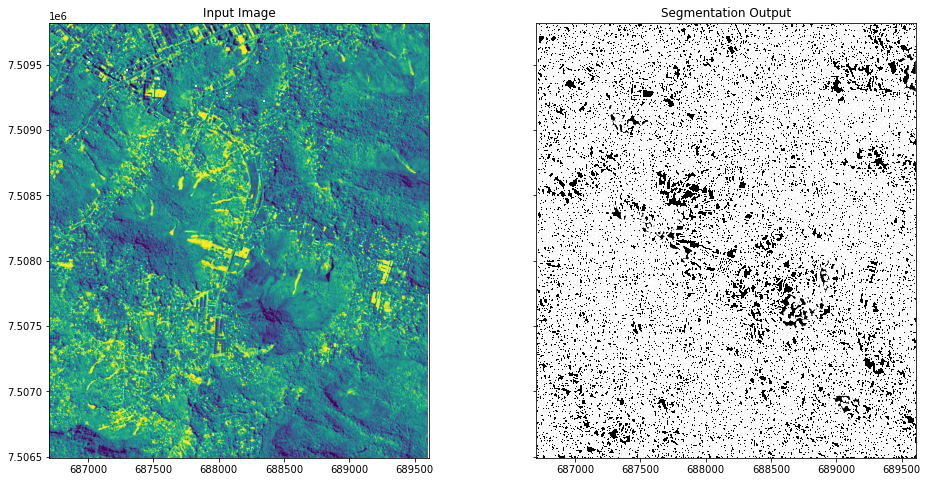

In [7]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [686704.7969035364, 689611.5396555802, 7506491.4942995785, 7509818.3444005065]

# Subset bbox reformated for geopandas
gp_img_bbox = [sub_img_bbox[0], sub_img_bbox[2], sub_img_bbox[1], sub_img_bbox[3]]

# Use geopandas to read the vector layer
segs_gdf = geopandas.read_file(segs_vec_file, layer=segs_vec_lyr, bbox=gp_img_bbox)

### Input image
# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[1], bbox=sub_img_bbox,
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)
ax1.title.set_text("Input Image")

# Plot the polygons with no face colour and an edge colour of yellow. 
# i.e., just the polygon outlines in yellow.
segs_gdf.plot(ax=ax2, facecolor="black", edgecolor="white")
ax2.imshow(img_data_strch, extent=img_coords)
ax2.title.set_text("Segmentation Output")
